# Practical 1: Predicting Efficiency of Organic Solar Cell

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.decomposition import PCA

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

# (1) Read in Data Files

##Read in Original Feature File
The goal is to obtain the target values (column: 'gap')

In [4]:
%%time
df_trainOR = pd.read_csv("train.csv")

CPU times: user 39.6 s, sys: 5.5 s, total: 45.1 s
Wall time: 48 s


In [5]:
Y_train = df_trainOR['gap']
del df_trainOR

In [80]:
Y_train.head()

0    1.19
1    1.60
2    1.49
3    1.36
4    1.98
Name: gap, dtype: float64

## Read in Feature Files created by SM and WF

In [6]:
%%time
df_trainSM =pd.read_csv("df_train_withSMFeatures.csv")
df_trainWF=pd.read_csv("train_rdkit.csv")

CPU times: user 1min, sys: 5.43 s, total: 1min 5s
Wall time: 1min 10s


In [7]:
df_trainSM.drop(["Unnamed: 0", "smiles"], axis=1,inplace=True)
df_trainWF.drop(["smiles"], axis=1,inplace=True)

In [8]:
%%time
df_train=pd.concat([df_trainSM,df_trainWF], axis=1)

CPU times: user 1.17 s, sys: 1.5 s, total: 2.67 s
Wall time: 3.09 s


In [9]:
print df_trainSM.shape[1]+df_trainWF.shape[1], df_train.shape[1]

381 381


In [10]:
df_train.head()

,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,feat_010,feat_011,feat_012,feat_013,feat_014,feat_015,feat_016,feat_017,feat_018,feat_019,feat_020,feat_021,feat_022,feat_023,feat_024,feat_025,feat_026,feat_027,feat_028,feat_029,feat_030,feat_031,feat_032,feat_033,feat_034,feat_035,feat_036,feat_037,feat_038,feat_039,feat_040,feat_041,feat_042,feat_043,feat_044,feat_045,feat_046,feat_047,feat_048,feat_049,feat_050,...,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,collections,descList,rdPartialCharges
0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,160.165038,0.000000,0.000000,0.00000,0.000000,0.000000,6.066367,0.000000,6.263163,6,4.417151,69.585094,0,13.731058,0,0.000000,0,53.112196,0,31.649068,0.000000,0,0,34.401759,28.234619,0.000000,0,0.000000,57.529347,0,52.328843,0,51.81,0,5.133462,0,0,0,0,0,0,16.133663,32.649541,NaN,NaN,NaN,NaN
1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,0.000000,9.967957,0.000000,0.00000,0.000000,35.325943,45.323790,28.552360,30.249831,6,0.000000,68.949014,0,9.967957,0,6.420822,0,64.082088,0,0.000000,15.624026,0,0,0.000000,29.007159,0.000000,0,17.678201,42.387409,0,44.723087,0,25.78,0,-0.611785,0,0,0,0,0,0,0.000000,46.667340,NaN,NaN,NaN,NaN
2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,0.000000,0.000000,0.000000,8.74708,11.336786,36.417508,44.753830,27.214679,21.247788,7,0.000000,70.970372,0,13.731058,0,6.420822,0,52.914821,0,21.697978,10.373451,0,0,23.064973,23.250659,6.420822,0,11.126903,41.787918,0,49.710325,0,41.57,0,2.651992,0,0,0,0,0,0,9.468067,38.491053,NaN,NaN,NaN,NaN
3,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5.760247,0,0,0.000000,0.000000,0.000000,0.00000,0.000000,40.996278,49.697689,22.887198,30.996293,7,4.417151,52.739304,0,4.983979,0,6.420822,0,68.596501,0,22.581078,20.874600,0,0,0.000000,24.023181,6.420822,0,11.126903,41.012149,0,56.281180,0,28.93,0,-0.473941,0,0,0,0,0,0,5.781605,44.081225,NaN,NaN,NaN,NaN
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11.407425,0,0,0.000000,4.983979,14.951936,8.74708,0.000000,6.066367,12.132734,27.741740,35.204189,7,8.834302,66.375451,0,28.682994,0,0.000000,0,49.576911,0,11.387856,0.000000,0,0,11.728187,28.682994,0.000000,0,0.000000,58.411213,0,66.035119,0,103.62,0,1.147669,0,0,0,0,0,0,20.986598,40.699067,NaN,NaN,NaN,NaN


In [11]:
colList = df_train.columns.tolist()

for col in colList:
    df_train[col] = df_train[col].astype('float64')

In [12]:
a = df_train.dtypes.values
counter=0
for i in a:
    if i == np.dtype('float64'):
        counter+=1
print 'Total Number of Columns: ', len(colList)
print 'Total Number of Columns as Float64:', counter

Total Number of Columns:  381
Total Number of Columns as Float64: 381


As seen above, we have some values with 'NaN'. We will replace these values with '0' as shown below.

In [13]:
df_train.fillna(value=0, inplace=True)
df_train.head()

,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,feat_010,feat_011,feat_012,feat_013,feat_014,feat_015,feat_016,feat_017,feat_018,feat_019,feat_020,feat_021,feat_022,feat_023,feat_024,feat_025,feat_026,feat_027,feat_028,feat_029,feat_030,feat_031,feat_032,feat_033,feat_034,feat_035,feat_036,feat_037,feat_038,feat_039,feat_040,feat_041,feat_042,feat_043,feat_044,feat_045,feat_046,feat_047,feat_048,feat_049,feat_050,...,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,collections,descList,rdPartialCharges
0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,160.165038,0.000000,0.000000,0.00000,0.000000,0.000000,6.066367,0.000000,6.263163,6,4.417151,69.585094,0,13.731058,0,0.000000,0,53.112196,0,31.649068,0.000000,0,0,34.401759,28.234619,0.000000,0,0.000000,57.529347,0,52.328843,0,51.81,0,5.133462,0,0,0,0,0,0,16.133663,32.649541,0,0,0,0
1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,0.000000,9.967957,0.000000,0.00000,0.000000,35.325943,45.323790,28.552360,30.249831,6,0.000000,68.949014,0,9.967957,0,6.420822,0,64.082088,0,0.000000,15.624026,0,0,0.000000,29.007159,0.000000,0,17.678201,42.387409,0,44.723087,0,25.78,0,-0.611785,0,0,0,0,0,0,0.000000,46.667340,0,0,0,0
2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,0.000000,0.000000,0.000000,8.74708,11.336786,36.417508,44.753830,27.214679,21.247788,7,0.000000,70.970372,0,13.731058,0,6.420822,0,52.914821,0,21.697978,10.373451,0,0,23.064973,23.250659,6.420822,0,11.126903,41.787918,0,49.710325,0,41.57,0,2.651992,0,0,0,0,0,0,9.468067,38.491053,0,0,0,0
3,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5.760247,0,0,0.000000,0.000000,0.000000,0.00000,0.000000,40.996278,49.697689,22.887198,30.996293,7,4.417151,52.739304,0,4.983979,0,6.420822,0,68.596501,0,22.581078,20.874600,0,0,0.000000,24.023181,6.420822,0,11.126903,41.012149,0,56.281180,0,28.93,0,-0.473941,0,0,0,0,0,0,5.781605,44.081225,0,0,0,0
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11.407425,0,0,0.000000,4.983979,14.951936,8.74708,0.000000,6.066367,12.132734,27.741740,35.204189,7,8.834302,66.375451,0,28.682994,0,0.000000,0,49.576911,0,11.387856,0.000000,0,0,11.728187,28.682994,0.000000,0,0.000000,58.411213,0,66.035119,0,103.62,0,1.147669,0,0,0,0,0,0,20.986598,40.699067,0,0,0,0


In [13]:
#To show the location of infinite values
df_trainWF.describe()

,BalabanJ,BertzCT,Chem,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,MaxEStateIndex,MaxPartialCharge,MinAbsEStateIndex,MinAbsPartialCharge,MinEStateIndex,MinPartialCharge,MolLogP,MolMR,MolWt,NHOHCount,NOCount,NumAliphaticCarbocycles,...,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,collections,descList,rdPartialCharges
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,6.890210e+05,1000000.000000,6.890210e+05,1000000.000000,689021.000000,1000000.000000,689021.000000,1000000.000000,1000000.00000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000,1000000.000000,1000000,1000000.000000,1000000,1000000.000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000.000000,1000000.000000,0,0,0,0
mean,1.655443,1485.253036,17.495660,14.033287,16.573034,13.259361,8.736618,11.397915,6.725980,9.512587,5.283915,8.416945,4.072493,7.235830,0.912844,0,0,4.142035,4.710678,21.545032,40.397980,12.629631,20.586349,53.061544,4.774445,403.799087,0.020800,-2.668207,26.749588,391.205126,1.703743e+07,14.702062,5.353628,1.964555,162.156722,5.070863,inf,5.070863,inf,0.569099,0.120883,0.333577,-0.382847,5.171774,115.41973,403.900646,0.604296,2.773740,0.459071,0.440512,...,1.257826,0.006566,0,51.216626,2.890369,0.864446,3.285386,8.866455,18.563375,26.567680,24.282831,15.352721,6.469043,2.611711,70.427175,0,10.529958,0.005737,2.947613,0,63.264556,0,12.973789,4.571295,0,0,18.081241,19.994123,1.471668,0,6.457605,57.574915,0,54.609691,0,37.647304,0,2.720625,0,0,0,0,0,0,6.862299,41.805376,NaN,NaN,NaN,NaN
std,0.164374,262.258960,2.056284,1.641629,2.263025,1.578246,1.061169,1.919951,0.880980,1.901953,0.786977,2.160078,0.701394,2.219603,2.820020,0,0,6.161760,8.115960,16.790938,15.958570,11.400279,12.539265,15.184279,4.106762,59.442889,0.028755,0.673911,3.171857,59.242584,2.624616e+07,1.882151,0.831754,0.368871,19.624461,0.986243,NaN,0.986243,NaN,0.317661,0.036024,0.565940,0.094804,1.925417,14.49125,59.235005,0.723377,1.543648,0.636637,0.623859,...,3.143855,0.284165,0,76.495539,4.149914,3.068197,5.680367,11.881173,19.236432,21.687734,20.590266,13.897445,0.854486,3.185697,19.228642,0,7.349268,0.206839,4.087735,0,12.771492,0,9.885384,5.949912,0,0,12.971566,10.455879,2.944601,0,7.314720,14.695033,0,11.105545,0,20.480178,0,2.061249,0,0,0,0,0,0,5.964515,6.863886,NaN,NaN,NaN,NaN
min,1.182577,397.754248,8.67

We also noticed some columns with 'inf' values which will be replaced by the 'max value recognized by float'

In [14]:
#1) Replace INF with MAX FLOAT VALUE
#---------------------------------------------
#max_floatVal = np.finfo(np.float64).max
#adjusted_maxFloatVal = max_floatVal/(10**10)
#print adjusted_maxFloatVal
#df_train = df_train.replace([np.inf, -np.inf], adjusted_maxFloatVal)

#2) Replace INF with 0
#---------------------------------------------
#df_train = df_train.replace([np.inf, -np.inf], 0)

#3) DROP COLUMN with INF
#--------------------------------------------
df_train = df_train.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")

In [15]:
df_train.shape

(1000000, 379)

In [15]:
df_train.describe()

,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,feat_010,feat_011,feat_012,feat_013,feat_014,feat_015,feat_016,feat_017,feat_018,feat_019,feat_020,feat_021,feat_022,feat_023,feat_024,feat_025,feat_026,feat_027,feat_028,feat_029,feat_030,feat_031,feat_032,feat_033,feat_034,feat_035,feat_036,feat_037,feat_038,feat_039,feat_040,feat_041,feat_042,feat_043,feat_044,feat_045,feat_046,feat_047,feat_048,feat_049,feat_050,...,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,collections,descList,rdPartialCharges
count,1000000.000000,1000000,1000000,1000000,1000000.000000,1000000.00000,1000000.000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000.000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000.000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000.000000,1000000,1000000,1000000,1000000,1000000,1000000,...,1000000.000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000,1000000.000000,1000000,1000000.000000,1000000,1000000.000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000.000000,1000000.000000,1000000,1000000,1000000,1000000
mean,0.642013,0,0,0,0.999987,0.47765,0.975860,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.385474,0,0,0,0,0,0,0,0,0,0,0,0.358453,0,0,0,0,0,0,0.005031,0,0,0,0,0,0,...,1.257826,0.006566,0,51.216626,2.890369,0.864446,3.285386,8.866455,18.563375,26.567680,24.282831,15.352721,6.469043,2.611711,70.427175,0,10.529958,0.005737,2.947613,0,63.264556,0,12.973789,4.571295,0,0,18.081241,19.994123,1.471668,0,6.457605,57.574915,0,54.609691,0,37.647304,0,2.720625,0,0,0,0,0,0,6.862299,41.805376,0,0,0,0
std,0.479409,0,0,0,0.003606,0.49950,0.153484,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.486707,0,0,0,0,0,0,0,0,0,0,0,0.479546,0,0,0,0,0,0,0.070751,0,0,0,0,0,0,...,3.143855,0.284165,0,76.495539,4.149914,3.068197,5.680367,11.881173,19.236432,21.687734,20.590266,13.897445,0.854486,3.185697,19.228642,0,7.349268,0.206839,4.087735,0,12.771492,0,9.885384,5.949912,0,0,12.971566,10.455879,2.944601,0,7.314720,14.695033,0,11.105545,0,20.480178,0,2.061249,0,0,0,0,0,0,5.964515,6.863886,0,0,0,0
min,0.000000,0,0,0,0.000000,0.00000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,...,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,21.399416,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0,0.000000,11.398589,0,0.000000,0,0.000000,0,-1.327460,0,0,0,0,0,0,0.000000,13.357515,0,0,0,0
25%,0.000000,0,0,0,1.000000,0.00000,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,...,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,56.404405,0,4.983979,0.000000,0.000000,0,53.982902,0,10.000827,0.000000,0,0,11.336786,13.731058,0.000000,0,0.000000,47.240963,0,47.941709,0,25.780000,0,1.344514,0,0,0,0,0,0,1.467041,37.257118,0,0,0,0
50%,1.000000,0,0,0,1.000000,0.00000,

In [16]:
#Reality Checks: 
#print 'Has the max value of a column with "inf" been replaced by a large value?: ', max(df_train.MaxEStateIndex)
print 'What are the total number of "NaN" occurences?: ', (np.isnan(df_train).sum()).sum()
print 'What are the total number of "inf" occurences?: ', (np.isinf(df_train).sum()).sum()

What are the total number of "NaN" occurences?:  0
What are the total number of "inf" occurences?:  0


In [16]:
%%time
#Nan values are replaced by 0, Infinity columns are dropped, 
df_train.to_csv('df_train_SM_and_WF_v1.csv')

Wall time: 3min 25s


In [17]:
#alternate df_train2
df_train2=pd.concat([df_trainSM,df_trainWF], axis=1)

#Convert alternate df_train2 columns to float
colList = df_train2.columns.tolist()
for col in colList:
    df_train2[col] = df_train2[col].astype('float64')

#3) DROP COLUMNs with NAN and INF
#--------------------------------------------
df_train2 = df_train2.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")

print df_train2.shape

(1000000, 373)


In [ ]:
%%time
#Nan and Infinity columns are dropped, 
df_train2.to_csv('df_train2_SM_and_WF_v1.csv')

In [17]:
del df_trainSM, df_trainWF

#(2) Regression (Non-PCA)

## Split into train-validate set

In [18]:
#Train and Val set on df_train
train_X, val_X, train_Y, val_Y = train_test_split(df_train, Y_train, train_size=0.7)

##Linear Regression

In [19]:
%%time
LR = LinearRegression()
LR.fit(train_X, train_Y)

CPU times: user 43.3 s, sys: 4.78 s, total: 48 s
Wall time: 26.9 s


RMSE for Simple Regression 0.189995654017


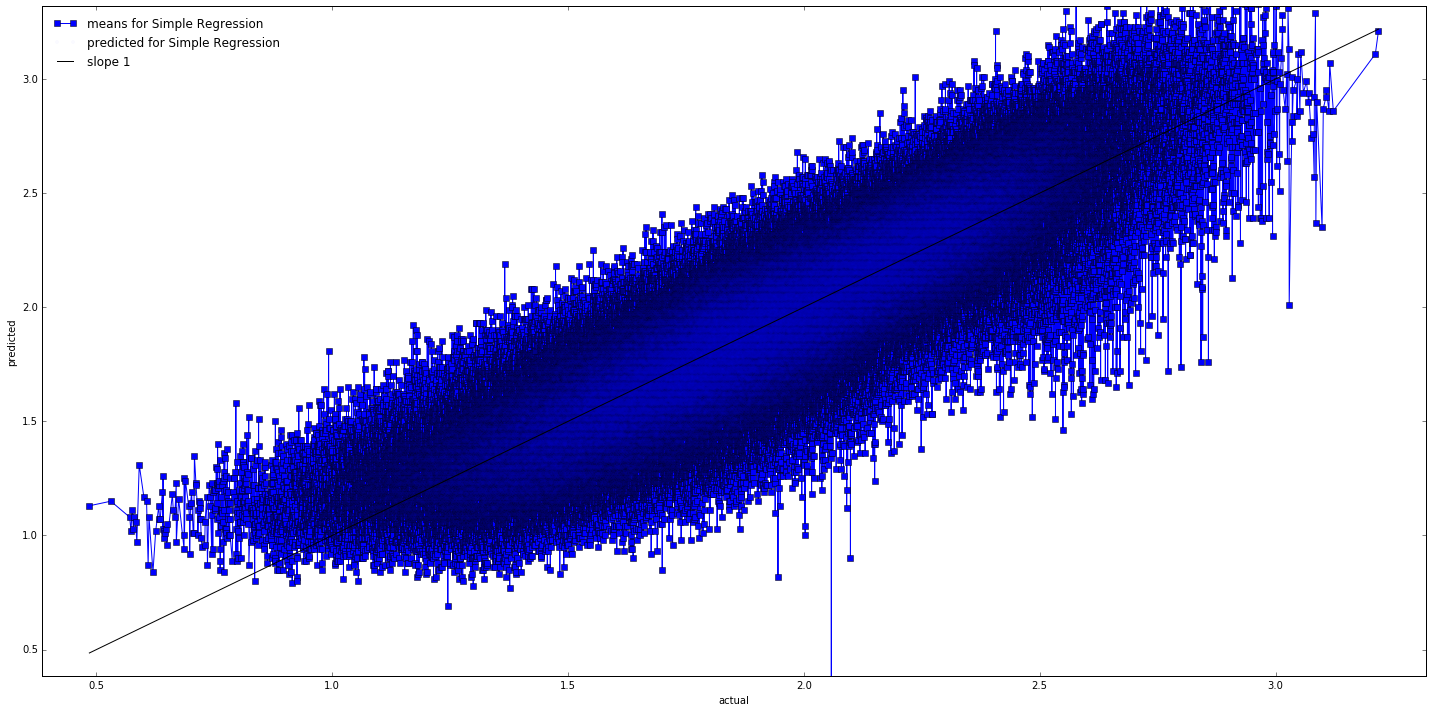

In [106]:
compare_results(LR.predict(val_X), val_Y, model="Simple Regression", predicteds=True);

In [20]:
## Root mean-squared error: 
err=mean_squared_error(LR.predict(val_X), val_Y)
print 'Root Mean Squared Error is: ', np.sqrt(err)

Root Mean Squared Error is:  0.189995654017


In [102]:
def compare_results(stars_actual, stars_predicted, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    lower = min(stars_actual)
    upper = max(stars_actual)
    
    fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), 
                         tight_layout=True)
    
    
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 's-', label="means for %s" % model)
    c=cl.get_color()

    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.02)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.02, label="predicted for %s" % model)

    if not onsame:
        ax.plot([lower,upper],[lower,upper], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([lower-0.1,upper+0.1])
        ax.set_xlim([lower-0.1, upper+0.1])
    ax.legend(frameon=False, loc="upper left")
    rmse=get_rmse(stars_actual, stars_predicted)
    print "RMSE for %s" % model, rmse
    return ax,rmse

In [ ]:
compare_results(testdf.stars,predictions['baseline'], model="baseline", predicteds=True);

## Ridge Regression

In [21]:
def cv_optimize(clf, X, y, parameters, n_folds=5, score_func="mean_squared_error"):
    #the scoring parameter below is the default one in ridge, but you can use a different one
    #in the cross-validation phase if you want.
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring= score_func)
    gs.fit(X, y)
    return gs

In [22]:
%%time

#-----------Model Inputs-------------------
clf = Ridge()
parameters = {"alpha": [1e-4, 1e-3, 1e-1, 1.0, 10, 100]}
score_func = "mean_squared_error"
#------------------------------------------

fitmodel = cv_optimize(clf, train_X, train_Y, parameters, n_folds=10, score_func=score_func)

CPU times: user 14min 15s, sys: 2min 38s, total: 16min 54s
Wall time: 8min 38s


In [82]:
%%time
#Fit with best alpha
alphawechoose = fitmodel.best_params_['alpha']
print 'Best alpha: ', alphawechoose
clf = Ridge(alpha=alphawechoose).fit(train_X,train_Y)

#Calculate error
pred_ridge = clf.predict(val_X)
err=mean_squared_error(pred_ridge, val_Y)
print 'Root Mean Squared Error is: ', np.sqrt(err)

Best alpha:  0.0001
Root Mean Squared Error is:  0.189995670989
CPU times: user 15.2 s, sys: 5.29 s, total: 20.5 s
Wall time: 14.4 s


In [ ]:
%time

#-----------Model Inputs-------------------
clf = Lasso()
#parameters = {"alpha": [1e-3, 1e-1, 1.0, 5, 10, 50, 100]}
parameters = {"alpha": [1e-4, 1e-3, 1e-1, 0.5, 1.0, 5, 10]}
score_func = "mean_absolute_error"
#------------------------------------------
fitmodel = cv_optimize(clf, train_X, train_Y, parameters, n_folds=10, score_func=score_func)

In [89]:
val_Y.tolist()

[2.2200000000000002,
 1.9099999999999999,
 1.8999999999999999,
 2.46,
 1.8899999999999999,
 1.2199999999999998,
 1.75,
 1.4099999999999997,
 1.1399999999999997,
 2.1000000000000001,
 1.3200000000000005,
 1.6899999999999995,
 1.3200000000000005,
 1.6100000000000003,
 2.5800000000000001,
 1.48,
 2.3700000000000001,
 2.5900000000000003,
 2.2300000000000004,
 2.0200000000000005,
 2.1900000000000004,
 1.4800000000000004,
 1.2000000000000002,
 1.8400000000000001,
 1.5200000000000005,
 1.6799999999999995,
 2.0800000000000001,
 2.4300000000000002,
 2.4199999999999999,
 2.0299999999999998,
 2.4500000000000002,
 2.1800000000000002,
 1.6399999999999999,
 1.99,
 1.9399999999999999,
 1.6299999999999994,
 2.8100000000000001,
 1.8300000000000001,
 1.8899999999999999,
 1.99,
 1.6300000000000003,
 2.3199999999999994,
 1.5,
 1.9099999999999999,
 2.0800000000000001,
 1.6899999999999999,
 1.7199999999999998,
 1.4499999999999995,
 2.48,
 1.6300000000000003,
 1.4300000000000002,
 2.0800000000000001,
 2.1099

In [92]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

RMSE for Ridge Regression 0.189995670989


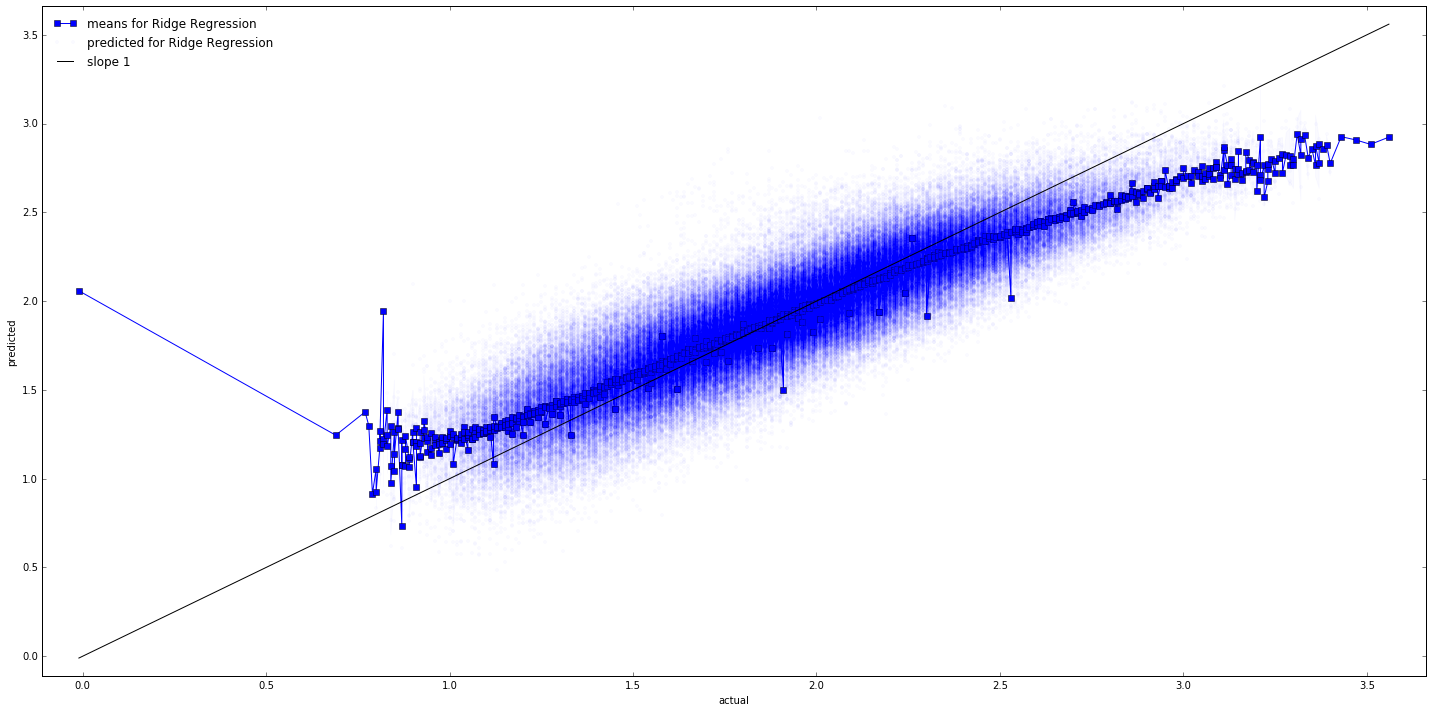

In [103]:
compare_results(np.array(val_Y.tolist()),np.array(pred_ridge.tolist()), model="Ridge Regression", predicteds=True);

##Simple Random Forest

In [24]:
%%time
RF = RandomForestRegressor()
RF.fit(train_X, train_Y)

#Calculate error
err=mean_squared_error(RF.predict(val_X), val_Y)
print 'Root Mean Squared Error is: ', np.sqrt(err)

Root Mean Squared Error is:  0.0990789083826
CPU times: user 8min 22s, sys: 3.37 s, total: 8min 25s
Wall time: 8min 26s


RMSE for Random Forest 0.0990789083826


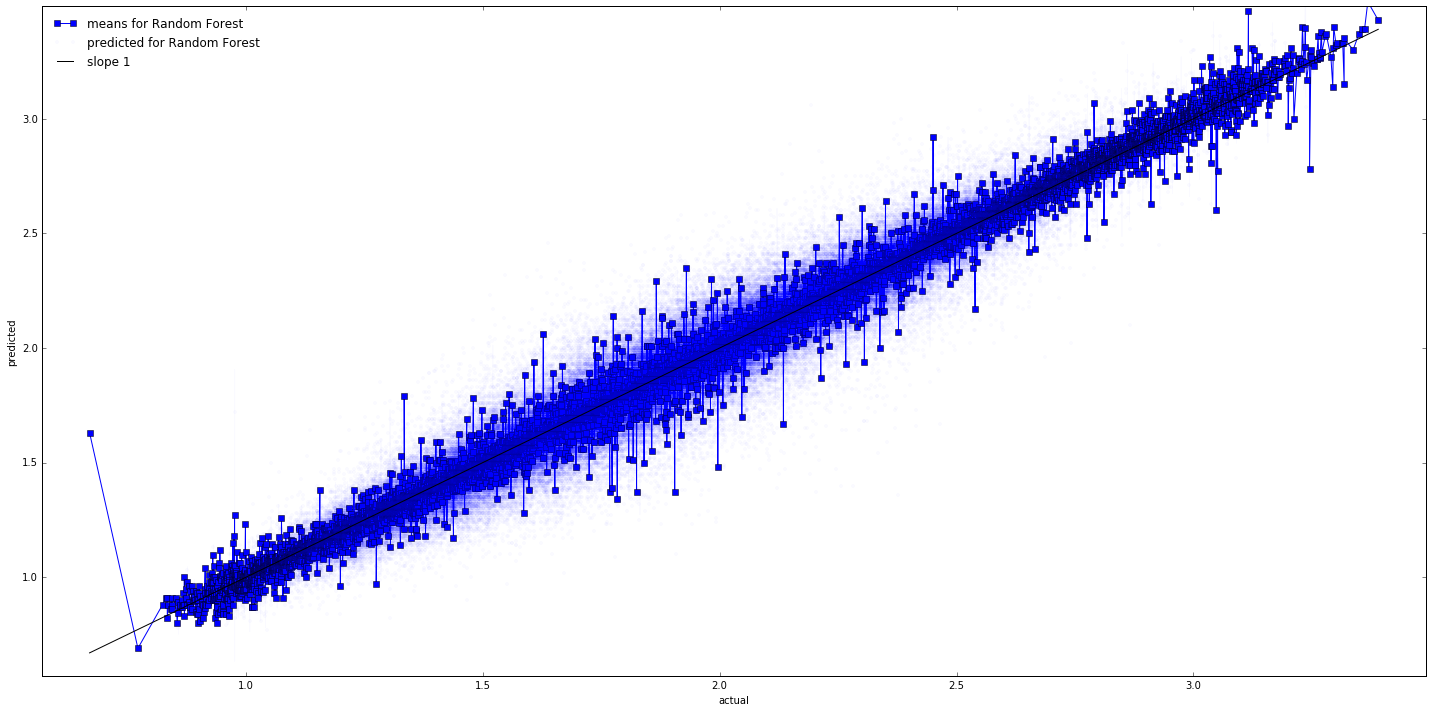

In [105]:
compare_results(RF.predict(val_X), val_Y, model="Random Forest", predicteds=True);

# Random Forest with Adaboost

In [107]:
%%time
RF_compare={}
trees = range(1,44,5)    
for tree in trees:
    clfForest1_ct = RandomForestRegressor(n_estimators=tree)
    clfForest1_ct.fit(train_X, train_Y)
    ypred= clfForest1_ct.predict(val_X)
    err = mean_squared_error(ypred, val_Y)
    rmse_lat = np.sqrt(err)
    RF_compare[tree]=rmse_lat

CPU times: user 2h 44min 42s, sys: 1min 45s, total: 2h 46min 27s
Wall time: 2h 48min 58s


In [108]:
RF_compare

{1: 0.1489333926596636,
 6: 0.10361379314778872,
 11: 0.098619065779401466,
 16: 0.096738682495936368,
 21: 0.095585507967098249,
 26: 0.094816461056217188,
 31: 0.094659101838371243,
 36: 0.094133721918614535,
 41: 0.093921378815034262}

In [79]:
RF_compare

{1: 0.15114331275681847,
 6: 0.10391598157134735,
 11: 0.098483121093483769,
 16: 0.097186591553408433}

# (3) Regression with PCA

In [19]:
%%time
pca = PCA(n_components=50, whiten=True).fit(df_train)
print "Explain variance for each PC is %s"%pca.explained_variance_ratio_
print "Total variance explained is %s"%pca.explained_variance_ratio_.sum()       
df_train_pca = pca.transform(df_train)

Explain variance for each PC is [  1.00000000e+00   6.07041180e-11   1.57651339e-11   3.19811881e-12
   1.58442244e-12   7.60886749e-13   4.27113648e-13   3.22842483e-13
   2.43411729e-13   2.02768417e-13   1.78552717e-13   1.39410346e-13
   1.18083399e-13   1.03391214e-13   8.75945004e-14   8.20808207e-14
   6.07884497e-14   5.38143854e-14   4.25506075e-14   3.27174572e-14
   2.12987474e-14   1.65323088e-14   1.24807298e-14   9.89940545e-15
   9.05395387e-15   8.15232130e-15   7.08479511e-15   6.28996576e-15
   5.65649169e-15   3.57051374e-15   2.89767086e-15   2.44143810e-15
   1.46651190e-15   1.25765245e-15   1.06265711e-15   1.00471009e-15
   8.54402112e-16   7.42802515e-16   5.92197520e-16   3.89889114e-16
   2.67335861e-16   2.30706281e-16   2.03804804e-16   1.80456827e-16
   1.72014610e-16   1.62834684e-16   1.48980160e-16   1.44799970e-16
   1.42162531e-16   1.23592838e-16]
Total variance explained is 1.0


## Split into train-validate set

In [26]:
#Train and Val set on the pca set: df_train_pca
train_X_pca, val_X_pca, train_Y_pca, val_Y_pca = train_test_split(df_train_pca, Y_train, train_size=0.7)

## Linear Regression

In [27]:
%%time
LR = LinearRegression()
LR.fit(train_X_pca, train_Y_pca)

Wall time: 2.34 s


In [28]:
## Root mean-squared error: 

RMSE_LR = np.sqrt(np.mean((LR.predict(val_X_pca)-val_Y_pca)**2))

err=mean_squared_error(LR.predict(val_X_pca), val_Y_pca)
print 'Root Mean Squared Error is: ', np.sqrt(err)

Root Mean Squared Error is:  0.207759764238


## Ridge Regression

In [29]:
%%time

#-----------Model Inputs-------------------
clf = Ridge()
#parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
parameters = {"alpha": [1e-4, 1e-3, 1e-1, 1.0, 10, 100]}
score_func = "mean_squared_error"
#------------------------------------------

fitmodel = cv_optimize(clf, train_X_pca, train_Y_pca, parameters, n_folds=10, score_func=score_func)

Wall time: 40.9 s


In [30]:
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

(Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, solver='auto', tol=0.001),
 {'alpha': 10},
 -0.042971648218448413,
 [mean: -0.04297, std: 0.00016, params: {'alpha': 0.0001},
  mean: -0.04297, std: 0.00016, params: {'alpha': 0.001},
  mean: -0.04297, std: 0.00016, params: {'alpha': 0.1},
  mean: -0.04297, std: 0.00016, params: {'alpha': 1.0},
  mean: -0.04297, std: 0.00016, params: {'alpha': 10},
  mean: -0.04297, std: 0.00016, params: {'alpha': 100}])

In [31]:
alphawechoose = fitmodel.best_params_['alpha']
print 'Best alpha: ', alphawechoose
clf = Ridge(alpha=alphawechoose).fit(train_X_pca, train_Y_pca)

Best alpha:  10


In [33]:
pred = clf.predict(val_X_pca)
err=mean_squared_error(pred, val_Y_pca)
print 'Root Mean Squared Error is: ', np.sqrt(err)

Root Mean Squared Error is:  0.207759764609


# Lasso Regression

In [34]:
%%time

#-----------Model Inputs-------------------
clf = Lasso()
#parameters = {"alpha": [1e-3, 1e-1, 1.0, 5, 10, 50, 100]}
parameters = {"alpha": [1e-4, 1e-3, 1e-1, 0.5, 1.0, 5, 10]}
score_func = "mean_absolute_error"
#------------------------------------------
fitmodel = cv_optimize(clf, train_X_pca, train_Y_pca, parameters, n_folds=10, score_func=score_func)

Wall time: 1min 45s


In [35]:
alphawechoose = fitmodel.best_params_['alpha']
print 'Best alpha: ', alphawechoose
clf = Lasso(alpha=alphawechoose).fit(train_X_pca,train_Y_pca)

Best alpha:  0.0001


In [36]:
pred = clf.predict(val_X_pca)
err=mean_squared_error(pred, val_Y_pca)
print 'Root Mean Squared Error is: ', np.sqrt(err)

Root Mean Squared Error is:  0.207760377112


# Random Forest

In [39]:
RF = RandomForestRegressor()
RF.fit(train_X_pca, train_Y_pca)

#Calculate error
err=mean_squared_error(RF.predict(val_X_pca), val_Y_pca)
print 'Root Mean Squared Error is: ', np.sqrt(err)

Root Mean Squared Error is:  0.146212927574


# Adaboost

#Create Predictions on TEST data

In [25]:
df_testWF = pd.read_csv('test_rdkit.csv')

In [26]:
df_testSM = pd.read_csv('df_test_withSMFeatures.csv')

In [30]:
df_testSM.drop(["Unnamed: 0", "smiles"], axis=1,inplace=True)
df_testWF.drop(["smiles"], axis=1,inplace=True)

In [58]:
df_train.head()

,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,feat_010,feat_011,feat_012,feat_013,feat_014,feat_015,feat_016,feat_017,feat_018,feat_019,feat_020,feat_021,feat_022,feat_023,feat_024,feat_025,feat_026,feat_027,feat_028,feat_029,feat_030,feat_031,feat_032,feat_033,feat_034,feat_035,feat_036,feat_037,feat_038,feat_039,feat_040,feat_041,feat_042,feat_043,feat_044,feat_045,feat_046,feat_047,feat_048,feat_049,feat_050,...,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,collections,descList,rdPartialCharges
0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,160.165038,0.000000,0.000000,0.00000,0.000000,0.000000,6.066367,0.000000,6.263163,6,4.417151,69.585094,0,13.731058,0,0.000000,0,53.112196,0,31.649068,0.000000,0,0,34.401759,28.234619,0.000000,0,0.000000,57.529347,0,52.328843,0,51.81,0,5.133462,0,0,0,0,0,0,16.133663,32.649541,0,0,0,0
1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,0.000000,9.967957,0.000000,0.00000,0.000000,35.325943,45.323790,28.552360,30.249831,6,0.000000,68.949014,0,9.967957,0,6.420822,0,64.082088,0,0.000000,15.624026,0,0,0.000000,29.007159,0.000000,0,17.678201,42.387409,0,44.723087,0,25.78,0,-0.611785,0,0,0,0,0,0,0.000000,46.667340,0,0,0,0
2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,0.000000,0.000000,0.000000,8.74708,11.336786,36.417508,44.753830,27.214679,21.247788,7,0.000000,70.970372,0,13.731058,0,6.420822,0,52.914821,0,21.697978,10.373451,0,0,23.064973,23.250659,6.420822,0,11.126903,41.787918,0,49.710325,0,41.57,0,2.651992,0,0,0,0,0,0,9.468067,38.491053,0,0,0,0
3,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5.760247,0,0,0.000000,0.000000,0.000000,0.00000,0.000000,40.996278,49.697689,22.887198,30.996293,7,4.417151,52.739304,0,4.983979,0,6.420822,0,68.596501,0,22.581078,20.874600,0,0,0.000000,24.023181,6.420822,0,11.126903,41.012149,0,56.281180,0,28.93,0,-0.473941,0,0,0,0,0,0,5.781605,44.081225,0,0,0,0
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11.407425,0,0,0.000000,4.983979,14.951936,8.74708,0.000000,6.066367,12.132734,27.741740,35.204189,7,8.834302,66.375451,0,28.682994,0,0.000000,0,49.576911,0,11.387856,0.000000,0,0,11.728187,28.682994,0.000000,0,0.000000,58.411213,0,66.035119,0,103.62,0,1.147669,0,0,0,0,0,0,20.986598,40.699067,0,0,0,0


In [56]:
df_test=pd.concat([df_testSM,df_testWF], axis=1)

In [59]:
df_test.head()

,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,feat_010,feat_011,feat_012,feat_013,feat_014,feat_015,feat_016,feat_017,feat_018,feat_019,feat_020,feat_021,feat_022,feat_023,feat_024,feat_025,feat_026,feat_027,feat_028,feat_029,feat_030,feat_031,feat_032,feat_033,feat_034,feat_035,feat_036,feat_037,feat_038,feat_039,feat_040,feat_041,feat_042,feat_043,feat_044,feat_045,feat_046,feat_047,feat_048,feat_049,feat_050,...,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,collections,descList,rdPartialCharges
0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.000000,9.967957,0,8.74708,11.336786,6.066367,30.331835,61.342313,28.278289,7,0.000000,77.579598,0,23.699016,0,0.000000,0,60.368796,0,10.440599,0.0000,0,0,23.064973,23.699016,0,0,0.000000,60.368796,0,64.955223,0,67.35,0,2.978831,0,0,0,0,0,0,9.241820,45.946015,NaN,NaN,NaN,NaN
1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.000000,0.000000,0,8.74708,22.673572,0.000000,29.645531,16.969292,42.732504,6,0.000000,76.640850,0,18.715037,0,0.000000,0,35.842375,0,10.571075,0.0000,0,0,34.401759,18.715037,0,0,0.000000,35.842375,0,52.810166,0,57.36,0,4.850646,0,0,0,0,0,0,9.165148,31.150873,NaN,NaN,NaN,NaN
2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,193.072309,0.000000,0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,8,0.000000,112.870871,0,13.731058,0,0.000000,0,56.469552,0,10.000827,10.4373,0,0,23.064973,37.754220,0,0,0.000000,46.032252,0,75.783564,0,41.57,0,3.206425,0,0,0,0,0,0,10.934518,43.553501,NaN,NaN,NaN,NaN
3,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.000000,4.983979,0,0.00000,0.000000,35.683363,50.880747,22.355516,32.510093,7,4.417151,65.648528,0,9.967957,0,6.420822,0,63.666442,0,11.454175,20.8746,0,0,0.000000,19.487558,0,0,6.420822,47.208993,0,67.583102,0,41.82,0,-0.329002,0,0,0,0,0,0,5.616635,48.156812,NaN,NaN,NaN,NaN
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,196.498424,0.000000,0,0.00000,0.000000,0.000000,6.066367,0.000000,6.263163,8,8.834302,112.858495,0,0.000000,0,0.000000,0,57.872274,0,29.262883,0.0000,0,0,56.683929,14.503561,0,0,0.000000,66.706576,0,70.933889,0,26.28,0,9.669612,0,0,0,0,0,0,13.422268,37.658120,NaN,NaN,NaN,NaN


In [60]:
df_test.fillna(value=0, inplace=True)

In [61]:
df_test = df_test.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")

In [68]:
print 'What are the total number of "NaN" occurences?: ', (np.isnan(df_test).sum()).sum()
print 'What are the total number of "inf" occurences?: ', (np.isinf(df_test).sum()).sum()

What are the total number of "NaN" occurences?:  0
What are the total number of "inf" occurences?:  0


In [69]:
df_test.shape

(824230, 379)

In [70]:
output = RF.predict(df_test)

In [71]:
length=output.shape[0]
length

824230

In [72]:
ids=[]
for i in xrange(length):
    ids.append(i+1)   

In [73]:
df_output = pd.DataFrame(zip(ids,output))
df_output.columns = ['Id', 'Prediction']
df_output = df_output.set_index(['Id'])
df_output.head()

,Prediction
Id,
1,2.043
2,1.920
3,1.447
4,1.387
5,1.487


In [74]:
df_output.to_csv('output.csv')